# Jores et al 2021 Training 
**Authorship:**
Adam Klie, *08/11/2022*
***
**Description:**
Notebook to perform simple training of models on the Jores et al dataset.
***

In [1]:
import os
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [2]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/jores21"

# Load data

## `leaf` `SeqData`

In [3]:
# Load in the preprocessed training data
sdata_leaf = eu.dl.read(os.path.join(eu.settings.dataset_dir, "leaf_processed_train.h5sd"))
sdata_leaf

SeqData object with = 65004 seqs
seqs = (65004,)
names = (65004,)
rev_seqs = None
ohe_seqs = (65004, 4, 170)
ohe_rev_seqs = (65004, 4, 170)
seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'train_val', 'type'
pos_annot: None
seqsm: None
uns: None

## `MotifSet` for conv initialization

In [4]:
from eugene.dataload.motif import _io
from copy import deepcopy

In [5]:
core_promoter_elements = _io.read_meme(os.path.join(eu.settings.dataset_dir, 'CPEs.meme'))
all_motifs = deepcopy(core_promoter_elements)
for motif in _io.read_meme(os.path.join(eu.settings.dataset_dir, 'TF-clusters.meme')):
    all_motifs.add_motif(motif)
all_motifs

MotifSet with 78 motifs

# Prep model

## Load from config

In [6]:
model = eu.models.load_config("Hybrid", "hybrid.yaml")
eu.models.init_weights(model)

## Initialize first conv layer

In [7]:
from eugene.dataload.motif import _convert
import torch.nn as nn

In [8]:
def get_layer(model, layer_name):
    return dict([*model.named_modules()])[layer_name]

In [9]:
layer = get_layer(model, 'conv1d_tower.layers.0')
pwms = _convert._to_array((256, 4, 13), all_motifs, convert_to_pwm=True)
layer.weight = nn.Parameter(pwms)

In [10]:
get_layer(model, 'conv1d_tower.layers.0').weight[0].T

tensor([[0.5100, 1.5060, 0.4780, 1.5060],
        [0.6300, 1.5940, 0.7960, 0.9820],
        [0.9960, 1.2120, 0.7880, 1.0040],
        [0.4940, 2.6200, 0.3020, 0.5820],
        [0.0400, 0.0080, 0.0080, 3.9440],
        [3.8720, 0.0000, 0.0000, 0.1280],
        [0.0080, 0.0560, 0.0240, 3.9120],
        [3.9680, 0.0000, 0.0080, 0.0240],
        [2.6120, 0.0480, 0.0080, 1.3320],
        [3.8960, 0.0000, 0.0320, 0.0720],
        [1.3640, 0.1120, 0.1440, 2.3820],
        [2.7820, 0.3260, 0.4780, 0.4140],
        [0.5020, 1.7280, 1.2660, 0.5020]], grad_fn=<PermuteBackward0>)

# Train leaf models

In [ ]:
# Define your augmentations

In [11]:
eu.train.fit(
    model=model, 
    sdata=sdata_leaf,
    gpus=1, 
    target_keys="enrichment",
    train_key="train_val",
    epochs=25,
    name="hybrid",
    batch_size=128,
    num_workers=4
)

Global seed set to 13


Dropping 0 sequences with NaN targets.
No transforms given, assuming just need to tensorize.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize.


Set SLURM handle signals.

  | Name            | Type           | Params
---------------------------------------------------
0 | train_metric    | R2Score        | 0     
1 | val_metric      | R2Score        | 0     
2 | test_metric     | R2Score        | 0     
3 | conv1d_tower    | Conv1DTower    | 1.7 M 
4 | recurrent_block | RecurrentBlock | 197 K 
5 | dense_block     | DenseBlock     | 8.4 K 
---------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

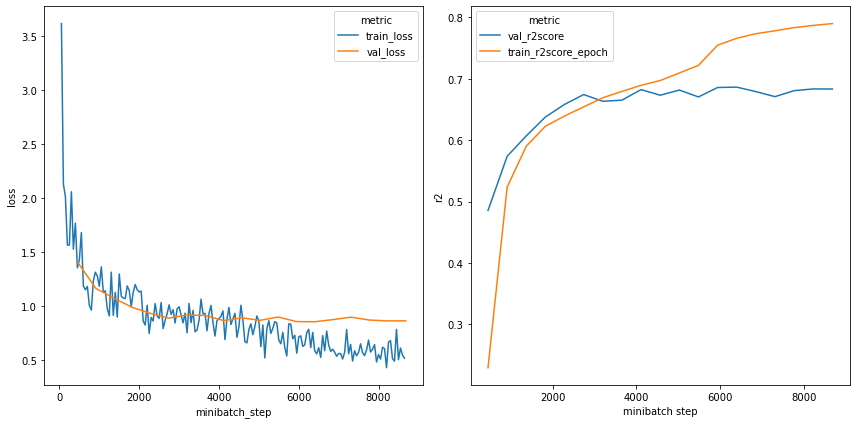

In [13]:
eu.pl.training_summary("eugene_logs/hybrid/version_9/")

---

# Scratch